<a href="https://colab.research.google.com/github/Black3rror/AI/blob/master/MNIST_deep_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

- Make custom layers - done
- Make custom model - done
- Make custom loss function
- Using GradientTape to compute gradients - done

# Look underhood

All operations are under supervision of TensorFlow, so it can calculate the gradients of all we do (when executing operation with GradientTape). In other word it can calculate gradient of anything (loss value) with respect to anything (all the trainable variables of the model).

So to introduce a layer we just need to introduce its trainable parameters (weights and biases) and how the output of the layer is computed.
Then the model is nothing but specifying the flow of input between these layers.

Loss function is just another bunch of operations done after the model outputed. Of course this loss can be a part of a bigger loss which includes regularization loss. Regularization loss can be simply another bunch of operations which has been done in the layers (e.g. L2 of weights) and will be added to the final loss function.

After that gradients with respect to all of the trainable parameters has been calculated, optimizer says that how to use these gradients to change the trainable parameters.

# Import stuff

In [ ]:
import numpy as np    # tf uses np so probabily we use np in our code
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, Softmax

import matplotlib.pyplot as plt   # if u want to show imgs by pyplot

from tensorflow.keras.callbacks import TensorBoard
import datetime   # to organize TensorBoard files

from keras.utils import to_categorical    # to change a number to one-hot key

In [ ]:
%load_ext tensorboard
!rm -rf ./logs/   # Clear any logs from previous runs

# Initialization

In [ ]:
#assert len(tf.config.list_physical_devices('GPU')) > 0

11493376/11490434 [==============================] - 0s 0us/step
trainX_shape:  (60000, 28, 28)
trainy_shape:  (60000,)
y related to the shown image:  5


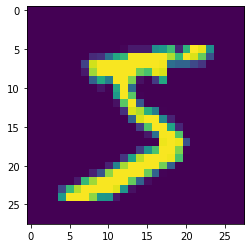

In [ ]:
(trainX, trainy_int), (testX, testy_int) = keras.datasets.mnist.load_data()

print("trainX_shape: ", trainX.shape)
print("trainy_shape: ", trainy_int.shape)

plt.imshow(trainX[0])
print("y related to the shown image: ", trainy_int[0])

# one-hot
trainy = to_categorical(trainy_int)
testy = to_categorical(testy_int)

# image should be in shape of (28, 28, 1) not (28, 28)
trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

# normalize
trainX = trainX.astype("float32")/255
testX = testX.astype("float32")/255

# Make custom classes

## Custom layers

### Dense

In [ ]:
class Dense_custom(Layer):
  def __init__(self, units, activation=None, **kwargs):
    super(Dense_custom, self).__init__(**kwargs)
    self.units = units
    self.activation = activation
  
  def build(self, input_shape):
    self.w = self.add_weight(name="weights", shape=(input_shape[1], self.units), 
                             initializer="glorot_uniform", trainable=True)
    self.b = self.add_weight(name="biases", shape=(self.units, ), 
                             initializer="zeros", trainable=True)
  
  def call(self, inputs):
    if self.activation == None:
      return tf.matmul(inputs, self.w) + self.b
    else:
      z = tf.matmul(inputs, self.w) + self.b
      act_layer = Activation(self.activation)
      return act_layer(z)

### Conv2D_custom

In [ ]:
class Conv2D_custom(Layer):
  def __init__(self, filters, kernel_size, strides=(1, 1), padding="VALID", activation=None, **kwargs):
    super(Conv2D_custom, self).__init__(**kwargs)
    self.filters_count = filters
    self.kernel_size = kernel_size
    self.strides = strides
    self.padding = padding
    self.activation = activation
  
  def build(self, input_shape):   # input_shape = [None (batch_size), img_height, img_width, img_depth]
    self.w = self.add_weight(name="weights", shape=(self.kernel_size[0], self.kernel_size[1], input_shape[3], self.filters_count), 
                             initializer="glorot_uniform", trainable=True)    # shape = (kernel_h, kernel_w, last_layer_d, self_layer_d)
    self.b = self.add_weight(name="biases", shape=(self.filters_count, ), 
                             initializer="zeros", trainable=True)
  
  def call(self, inputs):   # inputs shape: (batch_size (None), img_height, img_width, img_depth)
    if self.activation == None:
      return tf.nn.conv2d(inputs, self.w, self.strides, self.padding) + self.b
    else:
      z = tf.nn.conv2d(inputs, self.w, self.strides, self.padding) + self.b
      act_layer = Activation(self.activation)
      return act_layer(z)

## Custom model

In [ ]:
# bug: you can't call summary() before giving an input to the model or calling 
# fit(), even if you declared the input_shape
class Sequential_custom(Model):
  def __init__(self, layers=None, name=None):
    super(Sequential_custom, self).__init__()
    if layers == None:
      self.seq_layers = []
    else:
      self.seq_layers = layers
    self.model_name = name

  def add(self, layer):
    self.seq_layers.append(layer)

  def call(self, inputs):
    x = inputs
    for layer in self.seq_layers:
      x = layer(x)
    return x

# Build the model

In [ ]:
def build_model(conv1_units = 32, conv2_units = 64, dropout_rate = 0.5):
  #model = Sequential()
  model = Sequential_custom()

  #model.add(Conv2D(conv1_units, (3,3), activation='relu', input_shape = trainX.shape[1:]))
  model.add(Conv2D_custom(conv1_units, (3,3), activation='relu', input_shape = trainX.shape[1:]))

  model.add(MaxPooling2D((2, 2)))

  #model.add(Conv2D(conv2_units, (3,3), activation='relu'))
  model.add(Conv2D_custom(conv2_units, (3,3), activation='relu'))

  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dropout(dropout_rate))
  
  #model.add(Dense(10, activation='softmax'))
  model.add(Dense_custom(10, activation='softmax'))

  return model

In [ ]:
model = build_model()
#model.summary()

# Compile and fit

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
#%tensorboard --logdir logs/fit    # to run the TensorBoard in the notebook

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(trainX, trainy, epochs=10, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.2249 - categorical_accuracy: 0.9312 - val_loss: 0.0646 - val_categorical_accuracy: 0.9825
Epoch 2/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0872 - categorical_accuracy: 0.9735 - val_loss: 0.0441 - val_categorical_accuracy: 0.9888
Epoch 3/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0699 - categorical_accuracy: 0.9783 - val_loss: 0.0430 - val_categorical_accuracy: 0.9880
Epoch 4/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0580 - categorical_accuracy: 0.9818 - val_loss: 0.0369 - val_categorical_accuracy: 0.9893
Epoch 5/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0512 - categorical_accuracy: 0.9841 - val_loss: 0.0325 - val_categorical_accuracy: 0.9898
Epoch 6/10
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0468 - categorical_accuracy: 0.9846 - val_loss: 0.0348 - val_categorical_acc

In [ ]:
model.summary()

Model: "sequential_custom_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_custom_30 (Conv2D_cus multiple                  320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_custom_31 (Conv2D_cus multiple                  18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling multiple                  0         
_________________________________________________________________
flatten_15 (Flatten)         multiple                  0         
_________________________________________________________________
dropout_15 (Dropout)         multiple                  0         
_________________________________________________________________
dense_custom_15 (Dense_custo multiple         

# No model

In [ ]:
batch_size = 32
epochs = 10
loss_func = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam(learning_rate=0.003)

(valX, valy) = (trainX[-10000:], trainy[-10000:])

train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainy))

# layers
conv1 = Conv2D_custom(32, (3,3), activation='relu', input_shape = trainX.shape[1:])
conv2 = Conv2D_custom(64, (3,3), activation='relu')
dense = Dense_custom(10, activation='softmax')
max1 = MaxPooling2D((2, 2))
max2 = MaxPooling2D((2, 2))
flat = Flatten()
dropout = Dropout(0.5)

for i in range(epochs):
  print("Epoch: ", i)
  epoch_loss = 0

  train_dataset = train_dataset.shuffle(buffer_size=1024)
  train_batched = train_dataset.batch(batch_size)

  for step, (batchX, batchy) in enumerate(train_batched):
    with tf.GradientTape() as tape:
      # we could have a model and pass the model to it,
      # but instead we do that manually
      x = conv1(batchX)
      x = max1(x)
      x = conv2(x)
      x = max2(x)
      x = flat(x)
      x = dropout(x, training=True)
      x = dense(x)
      loss = loss_func(batchy, x)

    trainable_vars = conv1.trainable_weights + conv2.trainable_weights + dense.trainable_weights
    grads = tape.gradient(loss, trainable_vars)
    opt.apply_gradients(zip(grads, trainable_vars))

    epoch_loss += loss

    if step % 200 == 0:
      print("\tStep ", step, ":\t loss = ", epoch_loss.numpy()/(step+1))
  
  # epoch ended, validate it
  x = conv1(valX)
  x = max1(x)
  x = conv2(x)
  x = max2(x)
  x = flat(x)
  x = dropout(x, training=False)
  x = dense(x)
  val_loss = loss_func(valy, x)
  
  print("Epoch ", i, " ended.\t", "loss = ", epoch_loss.numpy()/len(train_batched), " ,\tval_loss = ", val_loss.numpy())

Epoch:  0
	Step  0 :	 loss =  2.304352283477783
	Step  200 :	 loss =  0.5012372904155978
	Step  400 :	 loss =  0.3453362291293251
	Step  600 :	 loss =  0.2741934067000962
	Step  800 :	 loss =  0.23165811641088288
	Step  1000 :	 loss =  0.21039996685443463
	Step  1200 :	 loss =  0.19224472109423787
	Step  1400 :	 loss =  0.17932576540961256
	Step  1600 :	 loss =  0.168869142454911
	Step  1800 :	 loss =  0.15904104517672474
Epoch  0  ended.	 loss =  0.15519287109375  ,	val_loss =  0.031682923
Epoch:  1
	Step  0 :	 loss =  0.23685216903686523
	Step  200 :	 loss =  0.0838245277974143
	Step  400 :	 loss =  0.08508751695590126
	Step  600 :	 loss =  0.08139631553814931
	Step  800 :	 loss =  0.07697209466560355
	Step  1000 :	 loss =  0.07726785543558004
	Step  1200 :	 loss =  0.07650873722581443
	Step  1400 :	 loss =  0.0757356871033804
	Step  1600 :	 loss =  0.07607384133085766
	Step  1800 :	 loss =  0.07425128400888395
Epoch  1  ended.	 loss =  0.07318690592447917  ,	val_loss =  0.02739184
E

In [ ]:
x = conv1(testX)
x = max1(x)
x = conv2(x)
x = max2(x)
x = flat(x)
x = dropout(x, training=False)
x = dense(x)

test_loss = loss_func(testy, x)
test_match = keras.metrics.categorical_accuracy(testy, x)
test_acc = np.sum(test_match)/len(test_match)

print("test_loss = ", test_loss.numpy(), ",\ttest_accuracy = ", test_acc)

test_loss =  0.029017111 ,	test_accuracy =  0.9905
